In [124]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import pyplot as plt, dates as mdates

from scipy.stats import pearsonr as pcr
from scipy.stats import spearmanr as spr

import seaborn as sns
import numpy as np
import matplotlib.colors as cm
import datetime
from datetime import timedelta
from tqdm import tqdm_notebook as tqdm
%matplotlib inline
%config Completer.use_jedi = False
import epiweeks as epi
import os, sys

In [125]:
def get_binning(temp,b):
    rbins=np.append(np.append(-np.inf,b),np.inf)
    rlabels=['OOR1',0,1,2,3,4,'OOR2']
    x=pd.cut(temp,bins=rbins,labels=rlabels)
    return x

In [126]:
# wwdf=pd.read_csv('input/ww_cases_hosp.csv',parse_dates=True)
wwdf=pd.read_csv('/project/biocomplexity/COVID-19_commons/data/VDH_wastewater/trimmed_combined_data_w_pop_weekof_agg_2023_03_05.csv')

In [127]:
lrdf=pd.DataFrame()
in_dir='input/cli_prediction_results/'
for f in os.listdir(in_dir):
    try:
        x=pd.read_csv(in_dir+f)
        x.loc[:,'location']=f.split('_')[0]
    except:
        print(f)
    lrdf=lrdf.append(x)

In [128]:
lrdf=lrdf.rename(columns={'case+ww':'CLI_VL','ww_only':'VL_only','case_only':'CLI_only'})

In [129]:
lrdf.date=pd.to_datetime(lrdf.date)

In [130]:
def conv_epiweek(dt):
    return epi.Week.fromdate(pd.to_datetime(dt)).startdate().strftime('%Y-%m-%d')

lrdf=lrdf.rename(columns={'cases':'Cases','ww':'Viral_Load','sewershed':'Sewershed'})
lrdf.date=lrdf.date.apply(lambda x: conv_epiweek(x))
lrdf.date=pd.to_datetime(lrdf.date)


In [131]:
for col in ['CLI_VL','VL_only','CLI_only']:
    lrdf.loc[:,'MAE_{}'.format(col)]=np.abs(lrdf[col]-lrdf['reported'])


/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'MAE')

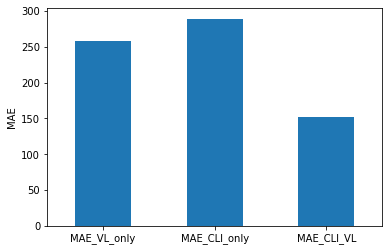

In [135]:
lrdf.mean()[['MAE_VL_only','MAE_CLI_only','MAE_CLI_VL']].plot(kind='bar',rot=0)
plt.ylabel('MAE')

/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  after removing the cwd from sys.path.


Text(0, 0.5, 'MAE')

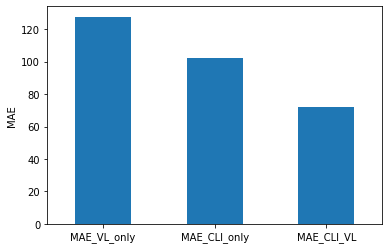

In [134]:
# lrdf.mean()[['VL_only','CLI_only','CLI_VL']].plot(kind='bar',rot=0)
# plt.ylabel('MAE')
mask=lrdf.date>='2022-06-01'
lrdf[mask].mean()[['MAE_VL_only','MAE_CLI_only','MAE_CLI_VL']].plot(kind='bar',rot=0)
plt.ylabel('MAE')

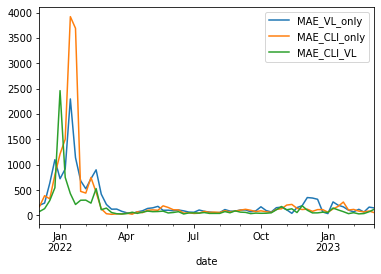

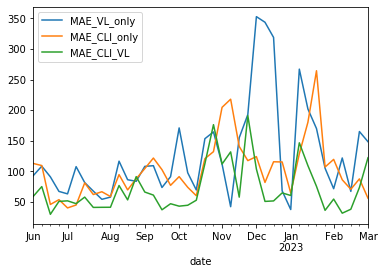

In [136]:
lrdf.groupby('date').mean().loc[:,['MAE_VL_only','MAE_CLI_only','MAE_CLI_VL']].plot()
lrdf[lrdf.date>='2022-06-01'].groupby('date').mean().loc[:,['MAE_VL_only','MAE_CLI_only','MAE_CLI_VL']].plot()

# plt.ylabel('MAE')

In [18]:
# lrdf.groupby(['location'])['reported'].transform(lambda x: pd.qcut(x, q=5, labels=range(0,5),duplicates='drop'))

In [138]:
locs=lrdf.location.unique()

In [139]:
qdf_reg=pd.DataFrame()
for loc in locs:
    try:
        temp=lrdf[lrdf.location==loc][['date','location','reported','CLI_VL','VL_only','CLI_only']]
        bins=range(5)
        temp.loc[:,'q_reported'],b=pd.qcut(temp['reported'],q=5,labels=bins,retbins=True)
        temp.loc[:,'bins_reported']=pd.qcut(temp['reported'],q=5)
        for col in ['CLI_VL','CLI_only','VL_only']:
            temp.loc[:,col+' (cat)']=get_binning(temp[col],b)
    except Exception as e:
        print(loc,e)
        continue
    qdf_reg=qdf_reg.append(temp)

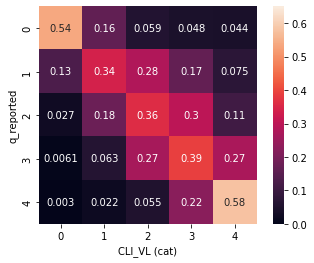

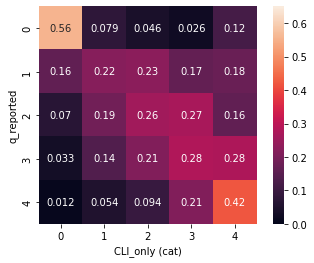

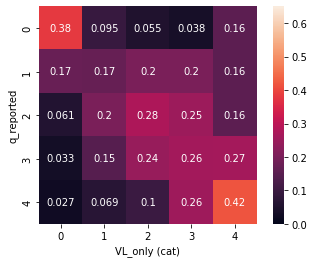

In [141]:
for col in ['CLI_VL','CLI_only','VL_only']:
    fig,ax=plt.subplots(figsize=(6,4))
    col1='q_reported'
    col2=col+ ' (cat)'
    htemp=qdf_reg[[col1,col2]].groupby([col1,col2]).size().reset_index().pivot(index=col1,columns=col2,values=0)
    rhtemp=htemp/htemp.sum(axis=1)
    rhtemp=rhtemp.loc[[0,1,2,3,4],[0,1,2,3,4]]
    sns.heatmap(rhtemp,annot=True,ax=ax,fmt='1.2',square=True,vmin=0,vmax=.65)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_xlabel(col2)

In [148]:
qdf_reg=pd.DataFrame()
for loc in locs:
    try:
        temp=lrdf[(lrdf.date>='2022-06-01')&(lrdf.location==loc)][['date','location','reported','CLI_VL','VL_only','CLI_only']]
        bins=range(5)
        temp.loc[:,'q_reported'],b=pd.qcut(temp['reported'],q=5,labels=bins,retbins=True)
        temp.loc[:,'bins_reported']=pd.qcut(temp['reported'],q=5)
        for col in ['CLI_VL','CLI_only','VL_only']:
            temp.loc[:,col+' (cat)']=get_binning(temp[col],b)
    except Exception as e:
        print(loc,e)
        continue
    qdf_reg=qdf_reg.append(temp)

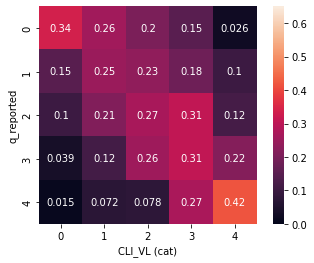

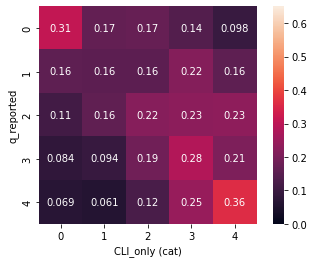

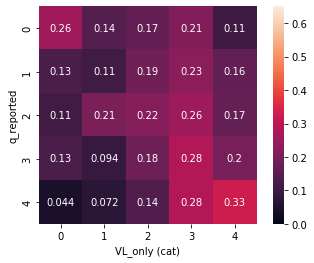

In [149]:
for col in ['CLI_VL','CLI_only','VL_only']:
    fig,ax=plt.subplots(figsize=(6,4))
    col1='q_reported'
    col2=col+ ' (cat)'
    htemp=qdf_reg[[col1,col2]].groupby([col1,col2]).size().reset_index().pivot(index=col1,columns=col2,values=0)
    rhtemp=htemp/htemp.sum(axis=1)
    rhtemp=rhtemp.loc[[0,1,2,3,4],[0,1,2,3,4]]
    sns.heatmap(rhtemp,annot=True,ax=ax,fmt='1.2',square=True,vmin=0,vmax=.65)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_xlabel(col2)

In [241]:
htemp.index

CategoricalIndex([0, 1, 2, 3, 4], categories=[0, 1, 2, 3, 4], ordered=True, name='q_reported', dtype='category')

In [265]:
for col in ['cases_VL','cases_only','VL_only']:
    pre=macro_recall(qdf_reg['q_reported'],qdf_reg[col+' (cat)'])
    pre
    print('{}: {}'.format(col,pre),sum(list(pre.values()))/5)

cases_VL: {3: 0.49201277798078985, 4: 0.5968253949307131, 2: 0.41390728339765803, 1: 0.3922829569379969, 0: 0.39221556768797733} 0.457448796187027
cases_only: {3: 0.3354632577141749, 4: 0.4984126968304359, 2: 0.2582781448401386, 1: 0.3408360117658006, 0: 0.38922155572089356} 0.36444233337428866
VL_only: {3: 0.373801915738652, 4: 0.504761903159486, 2: 0.2516556283057761, 1: 0.2765273303005552, 0: 0.23652694539961994} 0.32865474458081784


In [264]:
sum(list(pre.values()))/5

0.32865474458081784

In [104]:
pqdf_reg=qdf_reg.pivot(index='date',columns='location',values='q_reported')
pqdf_reg=pqdf_reg.ffill(axis=0)
temp=pqdf_reg.diff().fillna(0).melt(ignore_index=False,value_name='diff_q').reset_index()
qdf_reg=qdf_reg.merge(temp,on=['date','location'])


/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: dtype lost in 'diff()'. In the future this will raise a TypeError. Convert to a suitable dtype prior to calling 'diff'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [105]:
qdf_reg=qdf_reg.replace({'OOR1':np.nan,'OOR2':np.nan})
qdf_reg['q_reported']=qdf_reg['q_reported'].astype(int)
qdf_reg['q_reported']=qdf_reg['q_reported'].astype(int)

In [119]:
mask=(qdf_reg['diff_q']==1)&(qdf_reg.date>='2022-06-01')&(qdf_reg['CLI_VL (cat)']!='OOR1')&(qdf_reg['CLI_VL (cat)']!='OOR2')
temp_num=qdf_reg[mask&((qdf_reg.q_reported)==(qdf_reg['CLI_VL (cat)']))]
temp_den=qdf_reg[mask]

In [123]:
temp_num.groupby('location')['CLI_VL (cat)'].count().sum()/temp_den.groupby('location')['CLI_VL (cat)'].count().sum()

0.297029702970297

In [150]:
temp.groupby('location')['CLI_VL (cat)'].count()
temp_num=temp.groupby('location')['CLI_VL (cat)'].count()
temp_den=temp.groupby(['location'])['CLI_VL (cat)']

In [217]:
def macro_precision(y_true, y_pred):

    # find the number of classes
    num_classes = len(np.unique(y_true))

    # initialize precision to 0
    precision = 0
    temp_precision={}
    # loop over all classes
    for class_ in list(y_true.unique()):
        
        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        
        
        # compute true positive for current class
        tp = true_positive(temp_true, temp_pred)
        
        # compute false positive for current class
        fp = false_positive(temp_true, temp_pred)
        
        
        # compute precision for current class
        temp_precision[class_] = tp / (tp + fp + 1e-6)
        # keep adding precision for all classes
#         precision += temp_precision
        
    # calculate and return average precision over all classes
#     precision /= num_classes
    
    return temp_precision

def macro_recall(y_true, y_pred):

    # find the number of classes
    num_classes = len(np.unique(y_true))

    # initialize recall to 0
    recall = 0
    temp_recall={}

    # loop over all classes
    for class_ in list(y_true.unique()):
        
        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        
        
        # compute true positive for current class
        tp = true_positive(temp_true, temp_pred)
        
        # compute false negative for current class
        fn = false_negative(temp_true, temp_pred)
        
        
        # compute recall for current class
        temp_recall[class_] = tp / (tp + fn + 1e-6)
        
        # keep adding recall for all classes
    
    return temp_recall

def true_positive(y_true, y_pred):
    
    tp = 0
    
    for yt, yp in zip(y_true, y_pred):
        
        if yt == 1 and yp == 1:
            tp += 1
    
    return tp

def true_negative(y_true, y_pred):
    
    tn = 0
    
    for yt, yp in zip(y_true, y_pred):
        
        if yt == 0 and yp == 0:
            tn += 1
            
    return tn

def false_positive(y_true, y_pred):
    
    fp = 0
    
    for yt, yp in zip(y_true, y_pred):
        
        if yt == 0 and yp == 1:
            fp += 1
            
    return fp

def false_negative(y_true, y_pred):
    
    fn = 0
    
    for yt, yp in zip(y_true, y_pred):
        
        if yt == 1 and yp == 0:
            fn += 1
            
    return fn



In [151]:
def accuracy(y_true, y_pred):
    
    """
    Function to calculate accuracy
    -> param y_true: list of true values
    -> param y_pred: list of predicted values
    -> return: accuracy score
    
    """
    
    # Intitializing variable to store count of correctly predicted classes
    correct_predictions = 0
    
    for yt, yp in zip(y_true, y_pred):
        
        if yt == yp:
            
            correct_predictions += 1
    
    #returns accuracy
    return correct_predictions / len(y_true)

In [159]:
from sklearn.metrics import accuracy_score, precision_score

In [181]:
for col in ['cases_VL','cases_only','VL_only']:
    acc=accuracy(qdf_reg[col+' (cat)'],qdf_reg['q_reported'])
    print('{}: {}'.format(col,acc))

cases_VL: 0.45714285714285713
cases_only: 0.3657142857142857
VL_only: 0.32825396825396824


In [168]:
mask=(qdf_reg!='OOR1') & (qdf_reg!='OOR2')

In [173]:
preds=qdf_reg[mask][['VL_only (cat)','q_reported']].dropna()

In [212]:
pp=macro_precision(qdf_reg['q_reported'],qdf_reg[col+' (cat)'])

In [213]:
for col in ['cases_VL','cases_only','VL_only']:
    pre=macro_precision(qdf_reg['q_reported'],qdf_reg[col+' (cat)'])
    print('{}: {}'.format(col,pre))

cases_VL: {3: 0.4767801842824143, 4: 0.6064516109469303, 2: 0.4401408435206308, 1: 0.4265734250819111, 0: 0.609302322747431}
cases_only: {3: 0.3697183085573299, 4: 0.4231805918512653, 2: 0.326359831270461, 1: 0.39259259113854594, 0: 0.5327868830623489}
VL_only: {3: 0.3545454534710744, 4: 0.4732142843059099, 2: 0.28897338293166014, 1: 0.3282442735563196, 0: 0.409326422749604}


In [218]:
for col in ['cases_VL','cases_only','VL_only']:
    pre=macro_recall(qdf_reg['q_reported'],qdf_reg[col+' (cat)'])
    print('{}: {}'.format(col,pre))

cases_VL: {3: 0.49201277798078985, 4: 0.5968253949307131, 2: 0.41390728339765803, 1: 0.3922829569379969, 0: 0.39221556768797733}
cases_only: {3: 0.3354632577141749, 4: 0.4984126968304359, 2: 0.2582781448401386, 1: 0.3408360117658006, 0: 0.38922155572089356}
VL_only: {3: 0.373801915738652, 4: 0.504761903159486, 2: 0.2516556283057761, 1: 0.2765273303005552, 0: 0.23652694539961994}


In [116]:
get_binning(temp['VL_only'],b)

0        0
1        0
2        2
3        3
4        4
      ... 
83    OOR1
84       3
85       4
86       0
87    OOR1
Name: VL_only, Length: 88, dtype: category
Categories (7, object): ['OOR1' < 0 < 1 < 2 < 3 < 4 < 'OOR2']

In [26]:
for col in ['cases_VL','VL_only','cases_only']:
    lrdf.loc[:,'MAE_{}'.format(col)]=np.abs(lrdf[col]-lrdf['reported'])

In [3]:
# ww2=pd.read_csv('/project/biocomplexity/COVID-19_commons/data/VDH_wastewater/trimmed_combined_data_w_pop_weekof_agg_2023_03_05.csv')

In [14]:
locs=wwdf.Sewershed.unique()

In [73]:
wwdf.Attribute=pd.to_datetime(wwdf.Attribute)

In [7]:
qwwdf=wwdf[['Attribute','Sewershed','Viral_Load','Cases']]

In [17]:
qdf_bh=pd.DataFrame()
for loc in locs:
    try:
        temp=wwdf[wwdf.Sewershed==loc][['Attribute','Sewershed','Viral_Load','Cases']]
        bins=range(5)
        temp.loc[:,'q_Viral_Load']=pd.qcut(temp['Viral_Load'],q=5,labels=bins)
        temp.loc[:,'q_Cases']=pd.qcut(temp['Cases'],q=5,labels=bins)
    except:
        print(loc)
        continue
    qdf_bh=qdf_bh.append(temp)

Onancock


In [2]:
def conv_epiweek(dt):
    return epi.Week.fromdate(pd.to_datetime(dt)).startdate().strftime('%Y-%m-%d')

ccdata=pd.read_csv('/project/biocomplexity/COVID-19_commons/data/VDH_wastewater/trimmed_data_weekly_cc.csv')
ccdata=ccdata.rename(columns={'cases':'Cases','ww':'Viral_Load','sewershed':'Sewershed'})
ccdata.Attribute=ccdata.Attribute.apply(lambda x: conv_epiweek(x))
ccdata.Attribute=pd.to_datetime(ccdata.Attribute)


temp=ccdata[["Attribute",'Sewershed']]
ind=temp[temp.duplicated()].index
ccdata=ccdata.loc[~ccdata.index.isin(ind)]

In [137]:
qdf_cc=pd.DataFrame()
for loc in locs:
    try:
        temp=ccdata[ccdata.Sewershed==loc][['Attribute','Sewershed','Viral_Load','Cases']]
        bins=range(5)
        temp.loc[:,'q_Viral_Load']=pd.qcut(temp['Viral_Load'],q=5,labels=bins)
        temp.loc[:,'q_Cases']=pd.qcut(temp['Cases'],q=5,labels=bins)
    except:
        print(loc)
        continue
    qdf_cc=qdf_cc.append(temp)

In [138]:
qdf_bh.Attribute=pd.to_datetime(qdf_bh.Attribute)
qdf_cc.Attribute=pd.to_datetime(qdf_cc.Attribute)

In [31]:
loc='Richmond'
twwdf=qdf_bh[qdf_bh.Sewershed==loc]
twwdf=twwdf.set_index('Attribute')
# pdf=pd.DataFrame(index=np.arange(0,100),columns=['location','date','lag','pcorr','pval'])
win=12

#     for j in range(0,100):

endt=twwdf.index.max()-pd.Timedelta(weeks=0)
stdt=endt-pd.Timedelta(weeks=win-1)
for i in range(-2,3):
    temp1=twwdf.loc[stdt:endt,'Viral_Load']
    temp2=twwdf.shift(i).loc[stdt:endt,'Cases']
    ind=temp2[temp2.notna()].index
    x1=temp1.loc[ind].values
    x2=temp2.loc[ind].values
    px=spr(x1,x2)
    print(px)

SpearmanrResult(correlation=0.5714285714285715, pvalue=0.1389599571607067)
SpearmanrResult(correlation=0.6, pvalue=0.0876228290414024)
SpearmanrResult(correlation=0.6969696969696969, pvalue=0.02509667588225183)
SpearmanrResult(correlation=0.6242424242424242, pvalue=0.053717767217167395)
SpearmanrResult(correlation=0.6, pvalue=0.06668799999999996)


In [31]:
top10locs=wwdf[['Sewershed','total_pop']].drop_duplicates().sort_values('total_pop',ascending=False)[:10]['Sewershed'].values

In [32]:
top10locs

array(['Upper Occoquan', 'Alexandria Renew', 'Nansemond', 'Richmond',
       'Virginia Initiative Plant', 'HL Mooney', 'Williamsburg',
       'Lynchburg', 'Aquia', 'North River'], dtype=object)

In [5]:
wwdf.Attribute=pd.to_datetime(wwdf.Attribute)

In [6]:
twwdf=twwdf.fillna(method='ffill')

NameError: name 'twwdf' is not defined

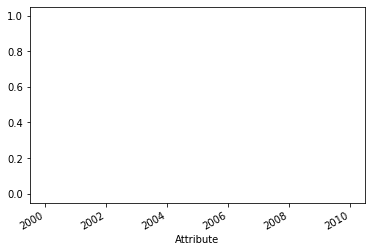

In [39]:
twwdf.loc[:,'Cases'].plot()

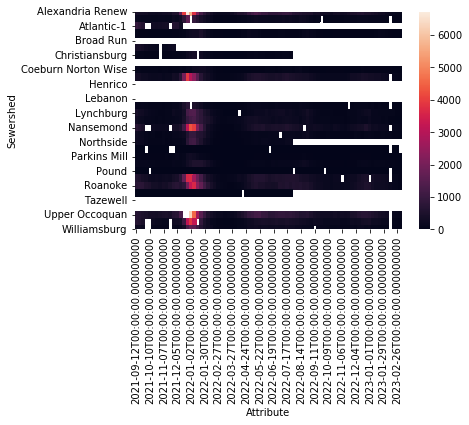

In [38]:
pwwdf=wwdf.pivot(index='Attribute',columns='Sewershed',values='Cases')
sns.heatmap(pwwdf.T)#,vmax=1e12)


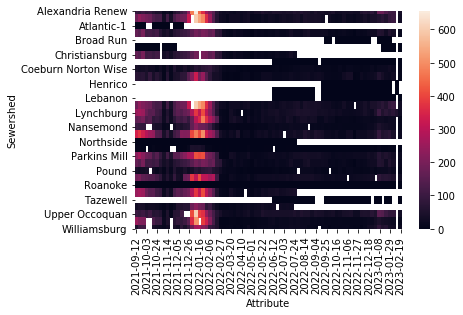

In [7]:
pwwdf=wwdf.pivot(index='Attribute',columns='Sewershed',values='hosp_frac_tot')
sns.heatmap(pwwdf.T)#,vmax=1e12)

<AxesSubplot:xlabel='Attribute', ylabel='Sewershed'>

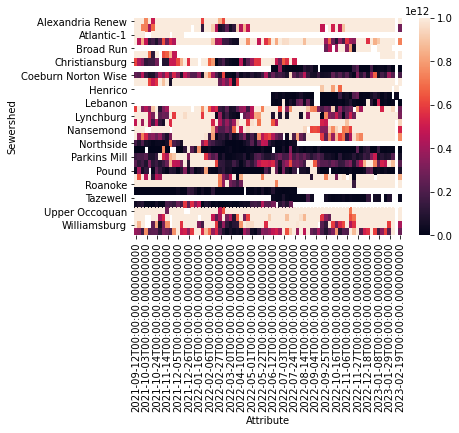

In [82]:
pwwdf=wwdf.pivot(index='Attribute',columns='Sewershed',values='Viral_Load')
sns.heatmap(pwwdf.T,vmax=1e12)

In [22]:
locs=wwdf.Sewershed.unique()

In [33]:
def get_roll_spear(wwdf,loc,shift=0):
    twwdf=wwdf[wwdf.Sewershed==loc]
    twwdf=twwdf.set_index('Attribute')
    pdf=pd.DataFrame(index=np.arange(0,100),columns=['location','date','lag','pcorr','pval'])
    win=12

    for j in range(0,100):

        endt=twwdf.index.max()-pd.Timedelta(weeks=j)
        stdt=endt-pd.Timedelta(weeks=win-1)
        if stdt<twwdf.index.min():
            break
        res=(np.nan,0,np.nan)
        for i in [shift]:
            temp1=twwdf.loc[stdt:endt,'Viral_Load']
            temp2=twwdf.shift(i).loc[stdt:endt,'Cases']
            ind=temp2[temp2.notna()].index
            x1=temp1.loc[ind].values
            x2=temp2.loc[ind].values
            px=spr(x1,x2)
    #         print(endt,i,pcr(x1,x2))
            if px[0]>res[1] and px[1]<=0.05:
                res=(i,px[0],px[1])
#             else:
#                 res=(i,np.nan,px[1])
#         print(endt,res)
        pdf.loc[j,'location']=loc
        pdf.loc[j,'date']=endt
        pdf.loc[j,'lag']=res[0]
        pdf.loc[j,'pcorr']=res[1]
        pdf.loc[j,'pval']=res[2]
    return pdf

In [139]:
locs=qdf_bh.Sewershed.unique()

In [45]:
alldf=pd.DataFrame()
for sh in range(-2,3):
    for loc in tqdm(locs):
        try:
            temp=get_roll_spear(qdf_bh,loc,shift=sh)
            temp=temp.dropna(subset=['location'])
            alldf=alldf.append(temp)
        except Exception as e:
            print(loc,e)
alldf.to_csv('output/spear_analy_BH_shifts.csv'.format(sh),index=None)

In [63]:
alldf.to_csv('output/spear_analy_BH_shifts.csv'.format(sh),index=None)

In [140]:
alldf=pd.DataFrame()
for sh in range(-2,3):
    for loc in tqdm(locs):
        try:
            temp=get_roll_spear(qdf_cc,loc,shift=sh)
            temp=temp.dropna(subset=['location'])
            alldf=alldf.append(temp)
        except Exception as e:
            print(loc,e)
# alldf.to_csv('output/spear_analy_CC_shifts.csv'.format(sh),index=None)

In [141]:
alldf.to_csv('output/spear_analy_CC_shifts.csv'.format(sh),index=None)

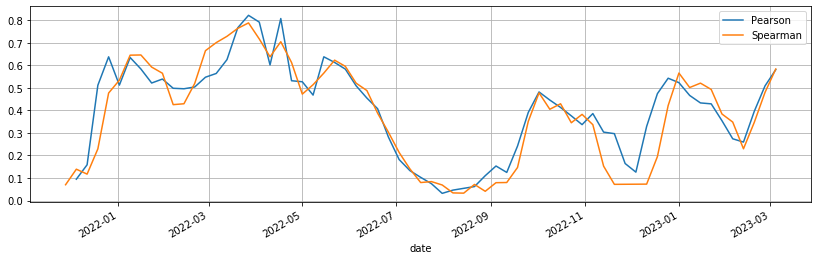

In [216]:
corr_cc=pd.read_csv('output/corr_analy_CC_shifts.csv',parse_dates=['date'])
cmap = sns.color_palette(as_cmap=True)
fig,ax=plt.subplots(figsize=(14,4))
k=0
for sh in range(0,1):
    tt=corr_cc[corr_cc['lag']==sh]
    ptt=tt.pivot(index='location',columns='date',values='pcorr').fillna(0)
    ptt.mean().plot(color=cmap[0],label='Pearson'.format(sh))
    k+=1
ax.legend()
ax.grid()


spear_cc=pd.read_csv('output/spear_analy_CC_shifts.csv',parse_dates=['date'])
spear_cc.date=pd.to_datetime(spear_cc.date)
# fig,ax=plt.subplots(figsize=(14,4))
k=0
for sh in range(0,1):
    tt=spear_cc[spear_cc['lag']==sh]
    ptt=tt.pivot(index='location',columns='date',values='pcorr').fillna(0)
    ptt.mean().plot(color=cmap[1],label='Spearman'.format(sh))
    k+=1
ax.legend()
ax.grid()

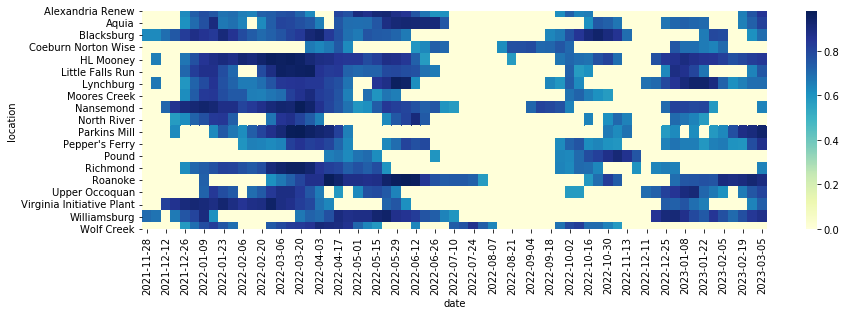

In [213]:
fig,ax=plt.subplots(figsize=(14,4))
ptt.columns=ptt.columns.strftime('%Y-%m-%d')
sns.heatmap(ptt,cmap='YlGnBu',ax=ax)

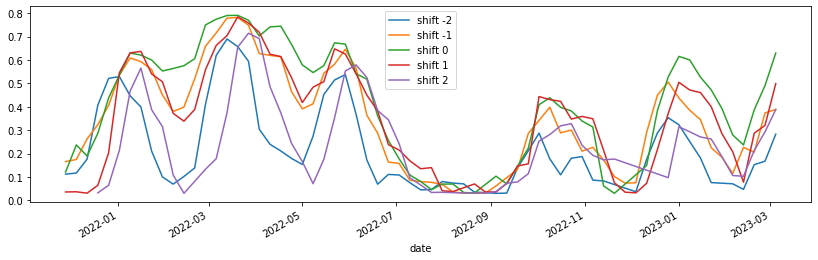

In [143]:
spear_bh=pd.read_csv('output/spear_analy_BH_shifts.csv',parse_dates=['date'])
spear_bh.date=pd.to_datetime(spear_bh.date)
cmap = sns.color_palette(as_cmap=True)
fig,ax=plt.subplots(figsize=(14,4))
k=0
for sh in range(-2,3):
    tt=spear_bh[spear_bh['lag']==sh]
    ptt=tt.pivot(index='location',columns='date',values='pcorr').fillna(0)
    ptt.mean().plot(color=cmap[k],label='shift {}'.format(sh))
    k+=1
plt.legend()

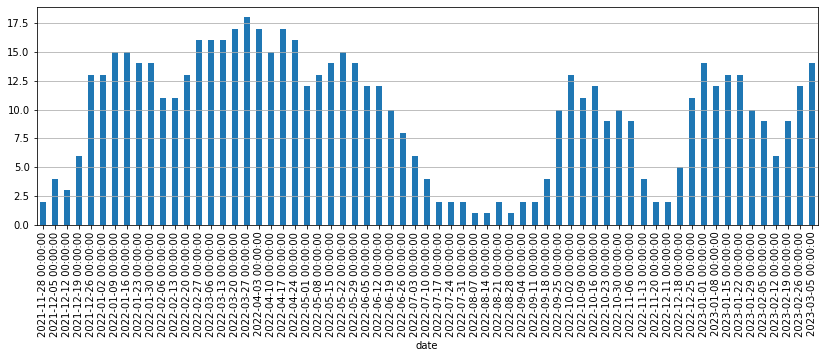

In [145]:
tt=spear_cc[spear_cc['lag']==0]
ptt=tt.pivot(index='location',columns='date',values='pcorr').fillna(0)
fig,ax=plt.subplots(figsize=(14,4))
ptt[ptt>=0.5].count().plot(kind='bar',ax=ax)
ax.grid(axis='y')

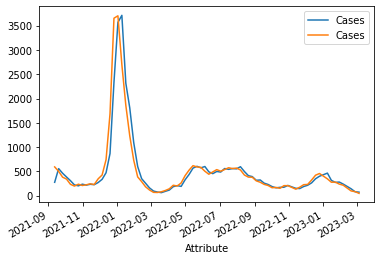

In [74]:
_,ax=plt.subplots()
ccdata[ccdata.Sewershed=='Richmond'].plot(x='Attribute',y='Cases',ax=ax)
wwdf[wwdf.Sewershed=='Richmond'].plot(x='Attribute',y='Cases',ax=ax)


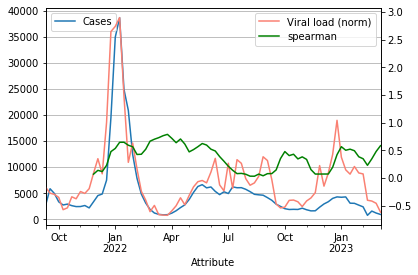

In [176]:
_,ax=plt.subplots()
ccdata.groupby('Attribute').sum()['Cases'].plot(ax=ax,label='Cases')
ax2=ax.twinx()
temp.mean(axis=1).plot(ax=ax2,color='salmon',label='Viral load (norm)')
spear_cc=pd.read_csv('output/spear_analy_CC_shifts.csv',parse_dates=['date'])
spear_cc.date=pd.to_datetime(spear_cc.date)
for sh in range(0,1):
    tt=spear_cc[spear_cc['lag']==sh]
    ptt=tt.pivot(index='location',columns='date',values='pcorr').fillna(0)
    ptt.mean().plot(label='spearman'.format(sh),ax=ax2,color='green')
    ax2.legend()
ax.legend(loc='upper left')
ax.grid(axis='y')

### z-score normalized

In [3]:
pccdata=ccdata.pivot(index='Attribute',columns='Sewershed',values='Viral_Load')
temp=(pccdata-pccdata.mean())/pccdata.std()


In [5]:
temp.to_csv('/project/biocomplexity/COVID-19_commons/data/VDH_wastewater/z-score_normalized_VL.csv')

Sewershed,Alexandria Renew,Aquia,Blacksburg,Coeburn Norton Wise,HL Mooney,Little Falls Run,Lynchburg,Moores Creek,Nansemond,North River,Onancock,Parkins Mill,Pepper's Ferry,Pound,Richmond,Roanoke,Upper Occoquan,Virginia Initiative Plant,Williamsburg,Wolf Creek
Attribute,,,,,,,,,,,,,,,,,,,,
2021-09-12,-0.611780,-0.245268,0.250943,0.176869,-0.321124,-0.400797,1.107600,-0.685122,-0.237685,0.450269,-0.283887,-0.314856,-0.480232,-0.249184,-0.341921,-0.107130,-0.502641,0.013679,-0.274276,-0.289314
2021-09-19,-0.748917,-0.213997,-0.642737,-0.006368,-0.278051,-0.030467,0.873541,-0.255886,-0.199315,-0.415159,-0.289951,-0.262594,-0.682647,0.375595,-0.638355,-0.525822,-0.529400,-0.268895,-0.367255,-0.361873
2021-09-26,-0.580783,-0.488789,-0.318778,1.147531,-0.294725,-0.633144,-0.173338,-0.730106,-0.212505,-0.138506,-0.287819,-0.265965,-0.584991,-0.222477,-0.425486,0.004406,-0.553413,-0.139382,-0.250333,-0.746010
2021-10-03,-0.796915,-0.490743,-0.622973,-0.343129,-0.611514,-0.529878,-0.096737,-0.402216,NaN,-0.298508,NaN,-0.186730,-0.754203,-0.090110,-0.665917,0.266947,-0.513619,NaN,NaN,0.530178
2021-10-10,-0.653109,-0.615044,-0.928027,-0.743279,-0.676400,-0.640265,-0.579323,-0.699213,NaN,-0.471121,-0.288552,-0.443656,-0.306225,NaN,-0.277415,-0.692269,-0.508816,NaN,NaN,-0.624366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-05,-0.033172,-0.171000,0.740748,-0.481795,0.224921,-0.091002,0.337335,-0.245046,0.538095,0.300514,-0.257502,-0.378919,0.764447,-0.287909,0.027522,-0.371387,0.086725,-0.162930,-0.058789,0.999678
2023-02-12,-0.732949,NaN,-0.759602,0.533439,NaN,NaN,-0.526128,0.215625,NaN,-0.512106,NaN,-0.491703,-0.629380,NaN,NaN,-0.706340,NaN,NaN,NaN,NaN
2023-02-19,-0.512214,-0.661559,-0.235425,0.196678,-0.558716,-0.674094,-0.015881,-0.694336,-0.374735,-0.188950,-0.274027,-0.500301,-0.604522,-0.216802,-0.609328,-0.620199,-0.549983,-0.149684,-0.540043,-0.526198


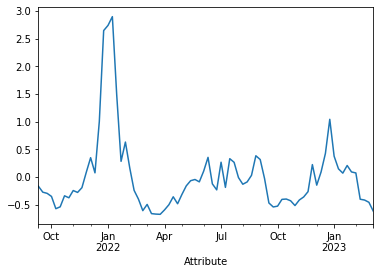

In [161]:
wwdf

,Unnamed: 0,Sewershed,Attribute,Viral_Load,Cases,cases_7d_fwd,cases_7d_pct_change,cases_all_pct_change_bins,vl_quintile_all
0,0,Alexandria Renew,2021-09-12,2.717689e+12,376.0,354.0,-0.058511,0.0,1.0
1,1,Alexandria Renew,2021-09-19,1.262965e+12,354.0,343.0,-0.031073,0.0,0.0
2,2,Alexandria Renew,2021-09-26,3.047256e+12,343.0,325.0,-0.052478,0.0,1.0
3,3,Alexandria Renew,2021-10-03,7.492935e+11,325.0,254.0,-0.218462,0.0,0.0
4,4,Alexandria Renew,2021-10-10,2.278222e+12,254.0,241.0,-0.051181,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1515,1959,Wolf Creek,2023-01-29,2.210000e+11,28.0,19.0,-0.321429,0.0,1.0
1516,1960,Wolf Creek,2023-02-05,9.850000e+11,19.0,21.0,0.105263,1.0,4.0
1517,1961,Wolf Creek,2023-02-19,2.700000e+11,19.0,19.0,0.000000,0.0,1.0
1518,1962,Wolf Creek,2023-02-26,1.360000e+12,19.0,9.0,-0.526316,0.0,4.0


In [162]:
th=qdf_cc[['q_Cases','q_Viral_Load']].groupby(['q_Cases','q_Viral_Load']).size().reset_index().pivot(index='q_Cases',columns='q_Viral_Load',values=0)

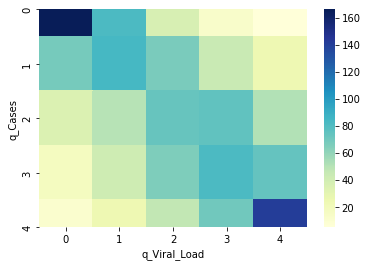

In [163]:
sns.heatmap(th,cmap="YlGnBu")

In [41]:
locs=ccdata.Sewershed.unique()

NameError: name 'ccdata' is not defined

In [28]:
wwdf_tr=wwdf[wwdf.Sewershed.isin(locs)]

In [29]:
len(wwdf_tr.Sewershed.unique())

20

In [34]:
alldf=pd.DataFrame()
for sh in range(-2,3):
    for loc in tqdm(locs):
        try:
            temp=get_roll_corr(wwdf_tr,loc,shift=sh)
            temp=temp.dropna(subset=['location'])
            alldf=alldf.append(temp)
        except Exception as e:
            print(loc,e)
alldf.to_csv('output/corr_analy_BH_{}.csv'.format(sh),index=None)

In [126]:
alldf=pd.DataFrame()
for sh in range(-2,3):
    for loc in tqdm(locs):
        try:
            temp=get_roll_corr(ccdata,loc,shift=sh)
            temp=temp.dropna(subset=['location'])
            alldf=alldf.append(temp)
        except Exception as e:
            print(loc,e)
alldf.to_csv('output/corr_analy_CC_shifts.csv',index=None)

Alexandria Renew array must not contain infs or NaNs
Blacksburg array must not contain infs or NaNs
Coeburn Norton Wise array must not contain infs or NaNs
Lynchburg array must not contain infs or NaNs
Moores Creek array must not contain infs or NaNs
North River array must not contain infs or NaNs
Parkins Mill array must not contain infs or NaNs
Pepper's Ferry array must not contain infs or NaNs
Roanoke array must not contain infs or NaNs



In [127]:
corr_cc=pd.read_csv('output/corr_analy_CC_shifts.csv',parse_dates=['date'])

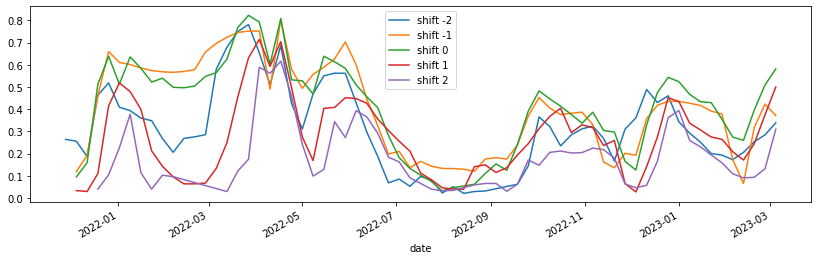

In [131]:
fig,ax=plt.subplots(figsize=(14,4))
k=0
for sh in range(-2,3):
    tt=corr_cc[corr_cc['lag']==sh]
    ptt=tt.pivot(index='location',columns='date',values='pcorr').fillna(0)
    ptt.mean().plot(color=cmap[k],label='shift {}'.format(sh))
    k+=1
plt.legend()

In [132]:
corr_bh=pd.read_csv('output/corr_analy_BH_shifts.csv',parse_dates=['date'])

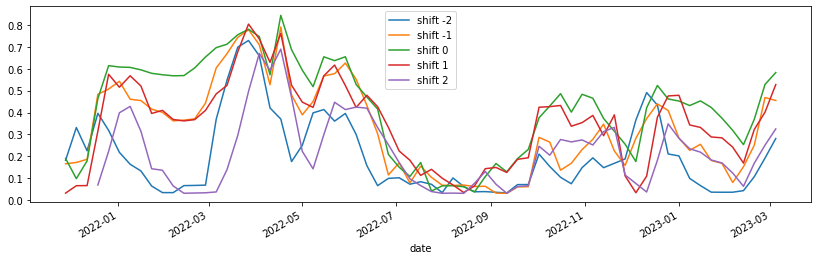

In [133]:
fig,ax=plt.subplots(figsize=(14,4))
k=0
for sh in range(-2,3):
    tt=corr_bh[corr_bh['lag']==sh]
    ptt=tt.pivot(index='location',columns='date',values='pcorr').fillna(0)
    ptt.mean().plot(color=cmap[k],label='shift {}'.format(sh))
    k+=1
plt.legend()

In [51]:
alldf=alldf.reset_index(drop=True)

In [52]:
alldf.date=pd.to_datetime(alldf.date)

In [53]:
alldf['lag']=alldf['lag'].astype(float)
alldf['pval']=alldf['pval'].astype(float)
alldf['pcorr']=alldf['pcorr'].astype(float)

In [54]:
alldf.dropna(subset=['pval']).mean()

<ipython-input-54-01a546f20391>:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  alldf.dropna(subset=['pval']).mean()


lag     -1.000000
pcorr    0.760056
pval     0.011722
dtype: float64

<AxesSubplot:title={'center':'pcorr'}, xlabel='[date]'>

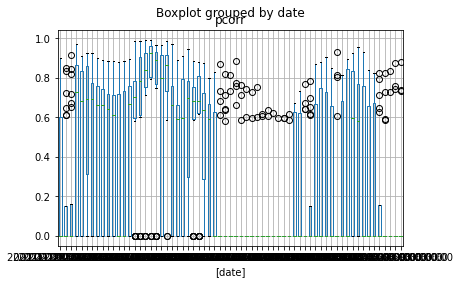

In [55]:
alldf[['date','pcorr']].boxplot(by='date')

Text(0.5, 1.0, 'Mean and Median correlation across all sites')

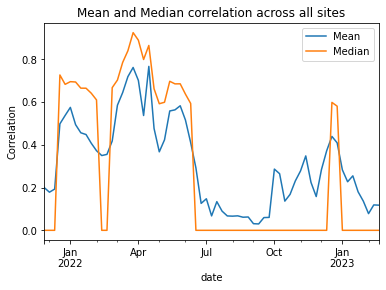

In [56]:
_,ax=plt.subplots()

alldf.groupby('date').mean()['pcorr'].plot(ax=ax,label='Mean')
alldf.groupby('date').median()['pcorr'].plot(ax=ax,label='Median')

ax.set_ylabel('Correlation')
ax.legend()
ax.set_title('Mean and Median correlation across all sites')

Text(0.5, 1.0, 'Mean and Median correlation across 10 sites')

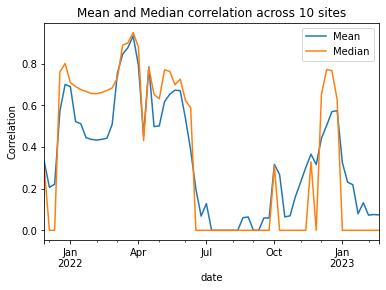

In [57]:
_,ax=plt.subplots()
mask=alldf.location.isin(top10locs)
alldf[mask].groupby('date').mean()['pcorr'].plot(ax=ax,label='Mean')
alldf[mask].groupby('date').median()['pcorr'].plot(ax=ax,label='Median')
ax.set_ylabel('Correlation')
ax.legend()
ax.set_title('Mean and Median correlation across 10 sites')

Text(0.5, 1.0, 'Correlation (all sites)')

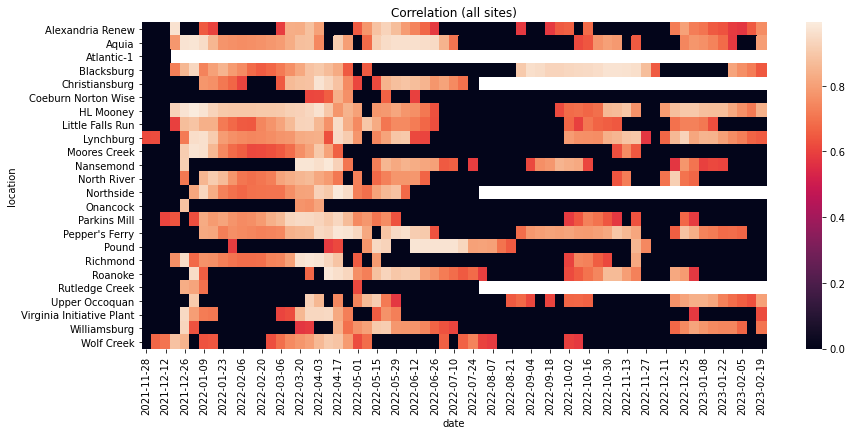

In [33]:
mask=alldf.location.isin(top10locs)
piv=alldf.pivot(index='location',columns='date',values='pcorr')
piv.columns=piv.columns.strftime('%Y-%m-%d')
fig,ax=plt.subplots(figsize=(14,6))
sns.heatmap(piv,ax=ax)
# fig.autofmt_xdate()
ax.set_title('Correlation (all sites)')
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

In [451]:
alldf

,location,date,lag,pcorr,pval
0,Alexandria Renew,2023-02-19,NaN,0.000000,NaN
1,Alexandria Renew,2023-02-12,NaN,0.000000,NaN
2,Alexandria Renew,2023-02-05,NaN,0.000000,NaN
3,Alexandria Renew,2023-01-29,NaN,0.000000,NaN
4,Alexandria Renew,2023-01-22,NaN,0.000000,NaN
...,...,...,...,...,...
1403,Rutledge Creek,2021-12-26,NaN,0.000000,NaN
1404,Rutledge Creek,2021-12-19,NaN,0.000000,NaN
1405,Rutledge Creek,2021-12-12,NaN,0.000000,NaN
1406,Rutledge Creek,2021-12-05,-2.0,0.828939,0.000859


Text(0.5, 1.0, 'Correlation (top 10 sites)')

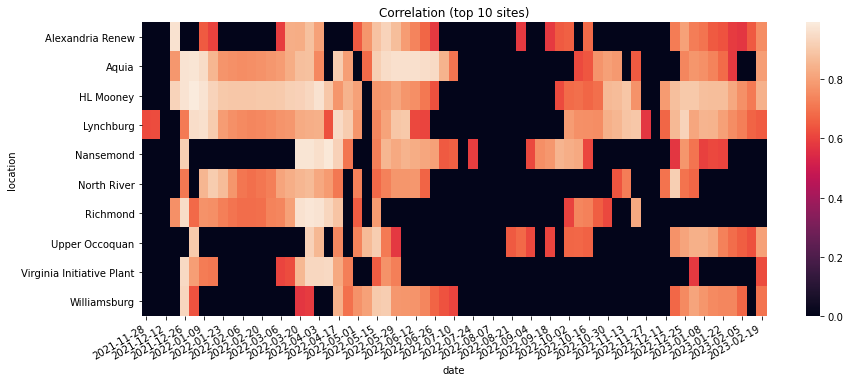

In [465]:
piv=alldf[mask].pivot(index='location',columns='date',values='pcorr')
piv.columns=piv.columns.strftime('%Y-%m-%d')
fig,ax=plt.subplots(figsize=(14,6))
sns.heatmap(piv,ax=ax)
fig.autofmt_xdate()
ax.set_title('Correlation (top 10 sites)')

In [325]:
# piv=alldf[mask].pivot(index='location',columns='date',values='lag')
# fig,ax=plt.subplots(figsize=(14,6))
# sns.heatmap(piv,ax=ax)
# fig.autofmt_xdate()

<AxesSubplot:label='8ff7aa2b-afa5-4c14-abac-fa6756790523', xlabel='Attribute'>

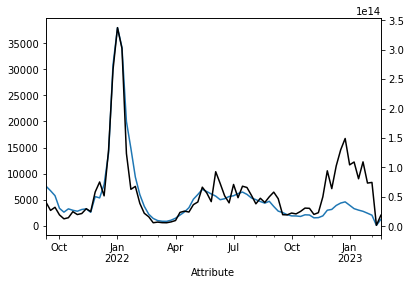

In [267]:
_,ax=plt.subplots()
wwdf.groupby('Attribute').sum()['Cases'].plot(ax=ax)
ax2=ax.twinx()
wwdf.groupby('Attribute').sum()['Viral_Load'].plot(ax=ax2,color='k')


<AxesSubplot:title={'center':'lag'}, xlabel='[date]'>

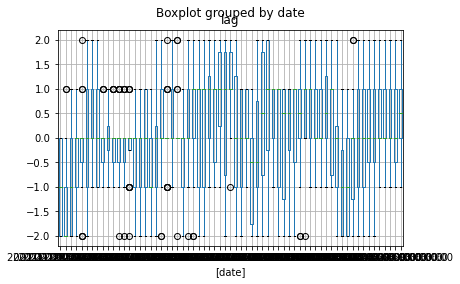

In [402]:
_,ax=plt.subplots()
alldf[['date','lag']].boxplot(by='date',ax=ax)


<AxesSubplot:xlabel='date'>

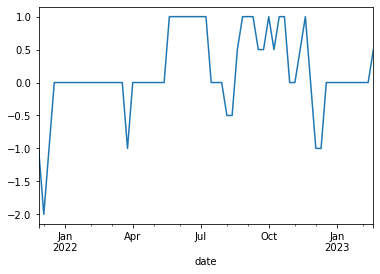

In [403]:
_,ax=plt.subplots()
alldf.groupby('date').median()['lag'].plot(ax=ax,label='Mean')

In [419]:
# alldf.loc[:,'lag_freq']=
alldf.groupby('date')['lag'].value_counts()#.pivot(index='lag',columns='date')

date        lag 
2021-11-28  -2.0    4
             0.0    4
            -1.0    3
2021-12-05  -2.0    9
            -1.0    4
                   ..
2023-02-12   2.0    2
2023-02-19   1.0    5
             0.0    4
            -1.0    3
             2.0    2
Name: lag, Length: 273, dtype: int64

### Granger causality

In [137]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np
data = sm.datasets.macrodata.load_pandas()
data = data.data[["realgdp", "realcons"]].pct_change().dropna()

In [215]:
data

,realgdp,realcons
1,0.025256,0.015404
2,-0.001192,0.010440
3,0.003501,0.001085
4,0.022438,0.009580
5,-0.004674,0.012652
...,...,...
198,-0.006758,-0.008908
199,-0.013710,-0.007812
200,-0.016475,0.001512
201,-0.001850,-0.002193


In [216]:
gc_res = grangercausalitytests(data, 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=28.7248 , p=0.0000  , df_denom=198, df_num=1
ssr based chi2 test:   chi2=29.1600 , p=0.0000  , df=1
likelihood ratio test: chi2=27.2295 , p=0.0000  , df=1
parameter F test:         F=28.7248 , p=0.0000  , df_denom=198, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=18.9880 , p=0.0000  , df_denom=195, df_num=2
ssr based chi2 test:   chi2=38.9498 , p=0.0000  , df=2
likelihood ratio test: chi2=35.5873 , p=0.0000  , df=2
parameter F test:         F=18.9880 , p=0.0000  , df_denom=195, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=13.5015 , p=0.0000  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=41.9812 , p=0.0000  , df=3
likelihood ratio test: chi2=38.0914 , p=0.0000  , df=3
parameter F test:         F=13.5015 , p=0.0000  , df_denom=192, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=10.9646 , p=0.0000  

In [138]:
grangercausalitytests?

Signature: grangercausalitytests(x, maxlag, addconst=True, verbose=True)
Docstring:
Four tests for granger non causality of 2 time series.

All four tests give similar results. `params_ftest` and `ssr_ftest` are
equivalent based on F test which is identical to lmtest:grangertest in R.

Parameters
----------
x : array_like
    The data for test whether the time series in the second column Granger
    causes the time series in the first column. Missing values are not
    supported.
maxlag : {int, Iterable[int]}
    If an integer, computes the test for all lags up to maxlag. If an
    iterable, computes the tests only for the lags in maxlag.
addconst : bool
    Include a constant in the model.
verbose : bool
    Print results.

Returns
-------
dict
    All test results, dictionary keys are the number of lags. For each
    lag the values are a tuple, with the first element a dictionary with
    test statistic, pvalues, degrees of freedom, the second element are
    the OLS estimation resul

,realgdp,realcons
1,0.025256,0.015404
2,-0.001192,0.010440
3,0.003501,0.001085
4,0.022438,0.009580
5,-0.004674,0.012652
...,...,...
198,-0.006758,-0.008908
199,-0.013710,-0.007812
200,-0.016475,0.001512
201,-0.001850,-0.002193
